In [98]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

In [99]:
#change tu_bs


In [100]:
bs_168 = Bitome('NC_000964.3_2.gb', gene_table = 'gene_info_supp_1.csv', tu_table = 'tu_bs_new.csv', tss_table = 'tss_bs.csv', riboswitch_table = 'riboswitch_bs.csv')


## Expression Distribution

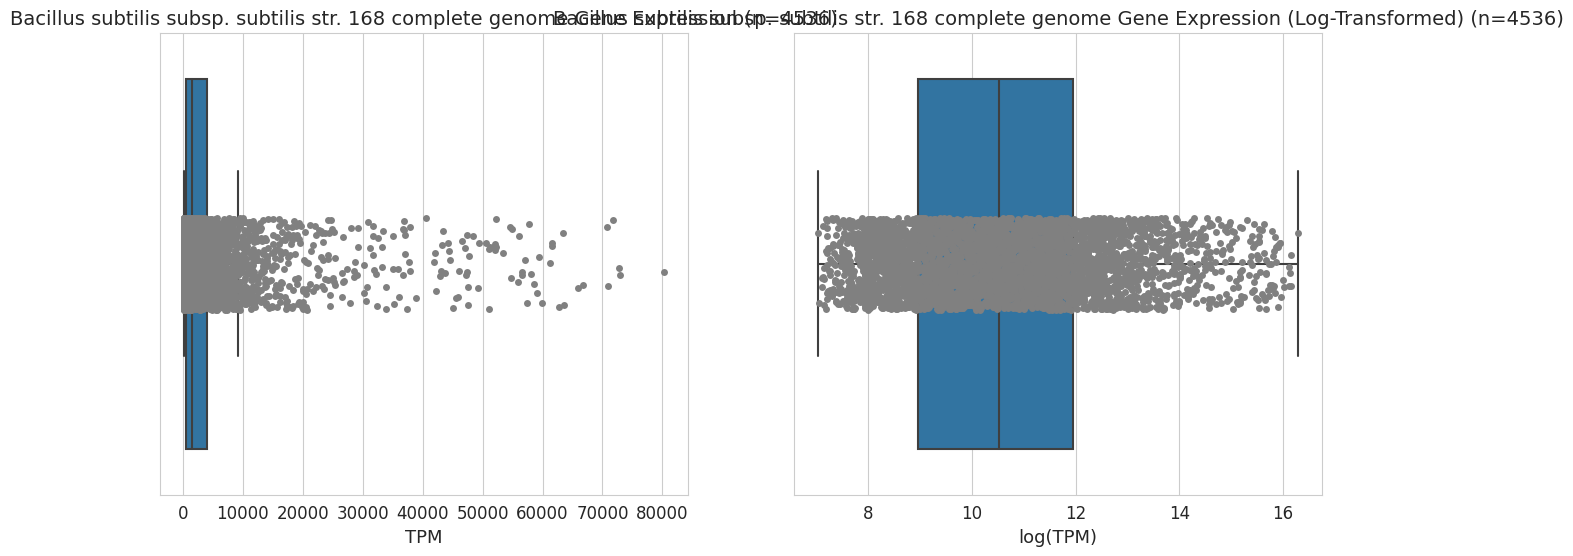

In [101]:
bs_168.expression_distribution();

## TU Expression Overview

reindexing with a non-unique Index is deprecated and will raise in a future version.


ValueError: cannot reindex on an axis with duplicate labels

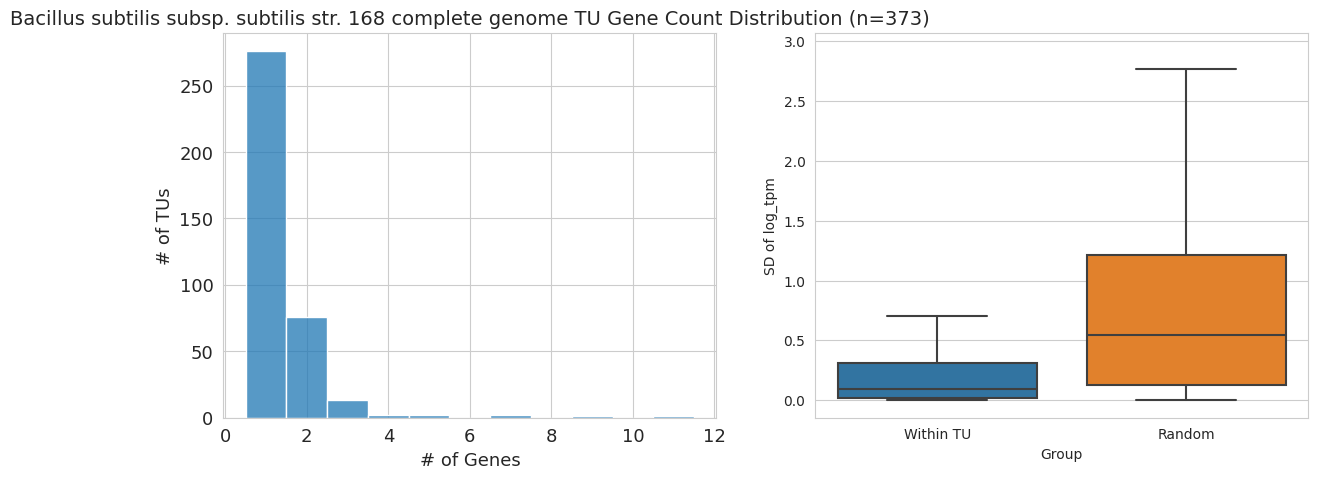

In [102]:
bs_168.within_tu_expression();

## Modeling - One-Hot Features Only

In [ ]:
Xy_to_try = {}
one_hot_tus = bs_168.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=10)
one_hot_tus.head()

In [ ]:
one_hot_tus_local = bs_168.one_hot_encode_tu_promoters(local_align=True, tss_radius=4, box_10_radius=10,
                                                      box_35_radius=10)
one_hot_tus_local.head()

## Gene Expression Based

In [ ]:
gene_names_avg = []
gene_oh_rows_avg = []
gene_exps_avg = []
gene_exps_avg_ctrl = []
gene_exps_avg_all = []

gene_names_1tss = []
gene_oh_rows_1tss = []
gene_exps_1tss = []
gene_exps_1tss_ctrl = []
gene_exps_1tss_all = []

gene_names_local_avg = []
gene_oh_rows_local_avg = []
gene_exps_local_avg = []
gene_exps_local_avg_ctrl = []
gene_exps_local_avg_all = []

gene_names_local_1tss = []
gene_oh_rows_local_1tss = []
gene_exps_local_1tss = []
gene_exps_local_1tss_ctrl = []
gene_exps_local_1tss_all = []

for gene_row in bs_168.gene_table.itertuples():
    
    # handle the normal 1-hot
    tus_for_gene = bs_168._gene_to_tus[gene_row.Index]
    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]
    gene_tpm = gene_row.tpm
    gene_tpm_ctrl = gene_row.tpm_ctrl
    gene_tpm_all = gene_row.tpm_all
    if tus_in_onehot and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_names_avg.append(gene_row.Index)
        gene_oh_rows_avg.append(tu_one_hot_avg)
        gene_exps_avg.append(gene_tpm)
        gene_exps_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_onehot) == 1:
            gene_names_1tss.append(gene_row.Index)
            gene_oh_rows_1tss.append(one_hot_tus.loc[tus_in_onehot[0]])
            gene_exps_1tss.append(gene_tpm)
            gene_exps_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_1tss_all.append(gene_tpm_all)
            
    # handle the local-aligned 1-hot
    tus_in_oh_loc = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus_local.index)]
    if tus_in_oh_loc and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots_loc = one_hot_tus_local.loc[tus_in_oh_loc, :]
        tu_one_hot_avg_loc = tu_one_hots_loc.mean(axis=0)
        gene_names_local_avg.append(gene_row.Index)
        gene_oh_rows_local_avg.append(tu_one_hot_avg_loc)
        gene_exps_local_avg.append(gene_tpm)
        gene_exps_local_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_local_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_oh_loc) == 1:
            gene_names_local_1tss.append(gene_row.Index)
            gene_oh_rows_local_1tss.append(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_exps_local_1tss.append(gene_tpm)
            gene_exps_local_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_local_1tss_all.append(gene_tpm_all)

X_avg = pd.DataFrame(gene_oh_rows_avg, index=gene_names_avg)
Xy_to_try['prom_avg__wt'] = (X_avg, pd.Series(gene_exps_avg, index=gene_names_avg))
Xy_to_try['prom_avg__ctrl'] = (X_avg, pd.Series(gene_exps_avg_ctrl, index=gene_names_avg))
Xy_to_try['prom_avg__all'] = (X_avg, pd.Series(gene_exps_avg_all, index=gene_names_avg))

X_1tss = pd.DataFrame(gene_oh_rows_1tss, index=gene_names_1tss)
Xy_to_try['1tss__wt'] = (X_1tss, pd.Series(gene_exps_1tss, index=gene_names_1tss))
Xy_to_try['1tss__ctrl'] = (X_1tss, pd.Series(gene_exps_1tss_ctrl, index=gene_names_1tss))
Xy_to_try['1tss__all'] = (X_1tss, pd.Series(gene_exps_1tss_all, index=gene_names_1tss))

X_local_avg = pd.DataFrame(gene_oh_rows_local_avg, index=gene_names_local_avg)
Xy_to_try['local_avg__wt'] = (X_local_avg, pd.Series(gene_exps_local_avg, index=gene_names_local_avg))
Xy_to_try['local_avg__ctrl'] = (X_local_avg, pd.Series(gene_exps_local_avg_ctrl, index=gene_names_local_avg))
Xy_to_try['local_avg__all'] = (X_local_avg, pd.Series(gene_exps_local_avg_all, index=gene_names_local_avg))

X_local_1tss = pd.DataFrame(gene_oh_rows_local_1tss, index=gene_names_local_1tss)
Xy_to_try['local_1tss__wt'] = (X_local_1tss, pd.Series(gene_exps_local_1tss, index=gene_names_local_1tss))
Xy_to_try['local_1tss__ctrl'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_ctrl, index=gene_names_local_1tss))
Xy_to_try['local_1tss__all'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_all, index=gene_names_local_1tss))

In [ ]:
Xy_to_try = {
    '1tss__wt': Xy_to_try['1tss__wt'],
    'prom_avg__wt': Xy_to_try['prom_avg__wt']
}

In [ ]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try)

In [ ]:
Xy_train

## Profile Models

In [ ]:
models_to_try = {
    #'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
}

In [ ]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing=['standard'], y_preprocessing=['log'],
                                                           verbose=True)

In [ ]:
model_profile_df

In [ ]:
to_plot_df = model_profile_df[
    (model_profile_df['model'] == 'RF')
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_train)
sns.swarmplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_train)
ax_train.get_legend().remove()
ax_train.set_xlabel('')
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_val)
sns.swarmplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
              loc='lower left', bbox_to_anchor=(1.05, 0.1))
ax_val.set_xlabel('')
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')

## Feature Importances

In [ ]:
x_oh_fi_raw = Xy_train['1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

## Random Forest Along Promoter

<AxesSubplot: xlabel='bp from TSS', ylabel='Feature Importance'>

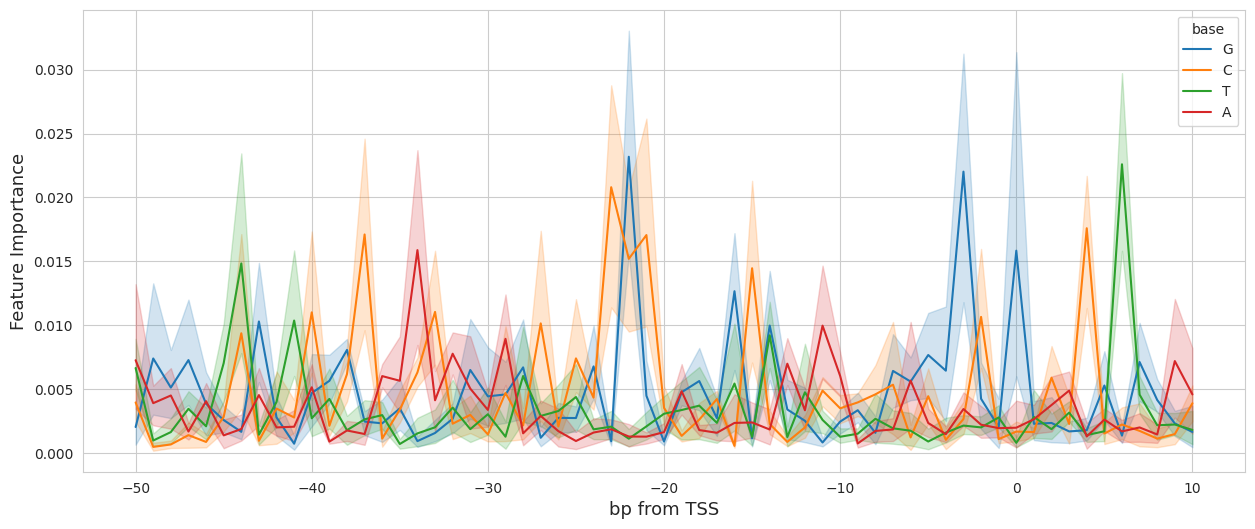

In [103]:
one_hot_feature_importance(x_oh_fi_std, y_oh_fi_raw, models_to_try['RF'], scoring='r2', n_cv=5)

## Shapley Values

In [104]:
x_oh_fi_std

,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,8_G,8_T,9_A,9_C,9_G,9_T,10_A,10_C,10_G,10_T
BSU_17910,-0.683872,-0.491078,1.787639,-0.575356,1.614768,-0.470658,-0.527395,-0.692046,-0.667602,-0.433235,...,-0.511310,1.525643,-0.603289,1.987138,-0.559397,-0.643366,-0.611282,-0.495138,-0.571367,1.584011
BSU_00900,1.462262,-0.491078,-0.559397,-0.575356,-0.619284,-0.470658,1.896111,-0.692046,1.497898,-0.433235,...,1.955761,-0.655461,1.657580,-0.503236,-0.559397,-0.643366,-0.611282,-0.495138,-0.571367,1.584011
BSU_27360,-0.683872,2.036337,-0.559397,-0.575356,1.614768,-0.470658,-0.527395,-0.692046,-0.667602,-0.433235,...,-0.511310,-0.655461,-0.603289,-0.503236,1.787639,-0.643366,-0.611282,2.019640,-0.571367,-0.631309
BSU_13490,-0.683872,-0.491078,1.787639,-0.575356,-0.619284,-0.470658,-0.527395,1.444991,-0.667602,-0.433235,...,-0.511310,1.525643,-0.603289,1.987138,-0.559397,-0.643366,1.635907,-0.495138,-0.571367,-0.631309
BSU_13509,-0.683872,-0.491078,1.787639,-0.575356,-0.619284,-0.470658,-0.527395,1.444991,-0.667602,-0.433235,...,-0.511310,1.525643,-0.603289,1.987138,-0.559397,-0.643366,-0.611282,-0.495138,-0.571367,1.584011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_12660,-0.683872,2.036337,-0.559397,-0.575356,-0.619284,-0.470658,1.896111,-0.692046,-0.667602,-0.433235,...,-0.511310,-0.655461,1.657580,-0.503236,-0.559397,-0.643366,-0.611282,-0.495138,1.750188,-0.631309
BSU_24770,-0.683872,-0.491078,-0.559397,1.738054,-0.619284,2.124685,-0.527395,-0.692046,-0.667602,-0.433235,...,1.955761,-0.655461,-0.603289,-0.503236,1.787639,-0.643366,1.635907,-0.495138,-0.571367,-0.631309
BSU_40530,1.462262,-0.491078,-0.559397,-0.575356,1.614768,-0.470658,-0.527395,-0.692046,1.497898,-0.433235,...,-0.511310,1.525643,1.657580,-0.503236,-0.559397,-0.643366,-0.611282,2.019640,-0.571367,-0.631309
BSU_15090,-0.683872,2.036337,-0.559397,-0.575356,1.614768,-0.470658,-0.527395,-0.692046,-0.667602,-0.433235,...,-0.511310,1.525643,-0.603289,1.987138,-0.559397,-0.643366,-0.611282,-0.495138,-0.571367,1.584011


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

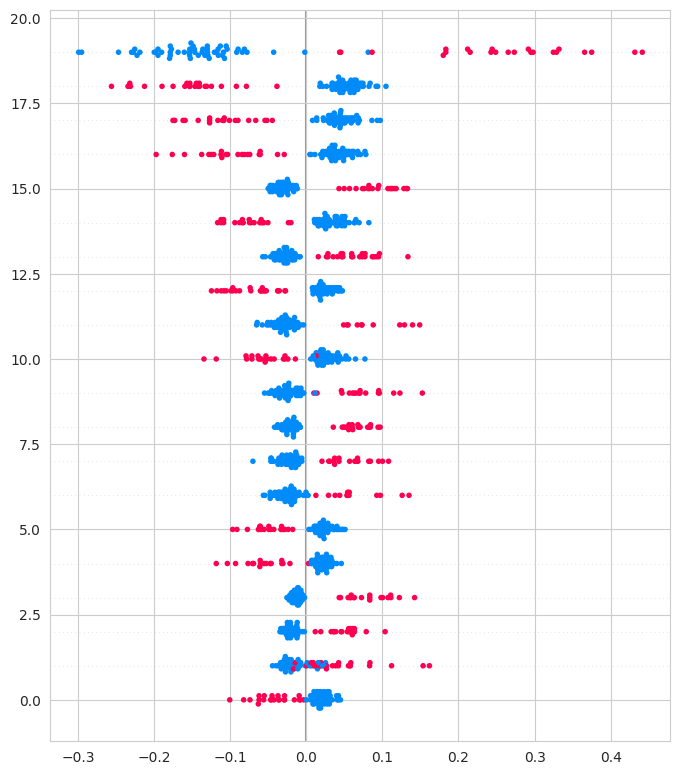

In [105]:
feature_importance(
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF']
)

### Predicted vs Actual

Text(0.5, 0.05, 'R-square: 0.21\nPearson R: 0.53 (P=4.88E-07)\nSpearman R: 0.31 (P=6.41E-03)')

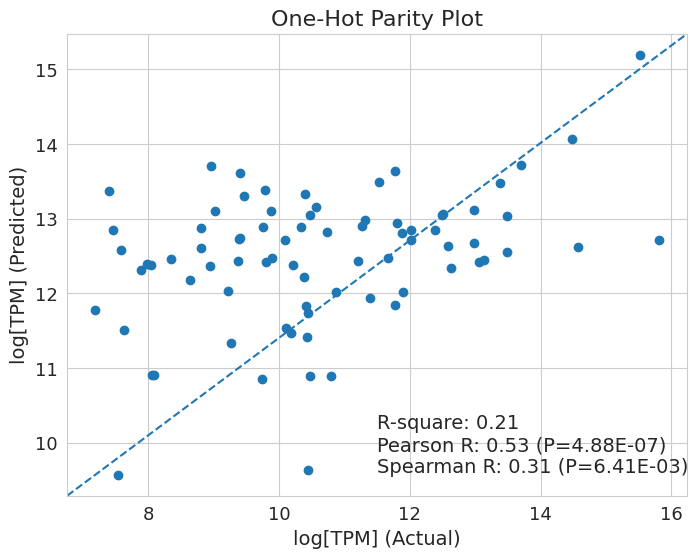

In [106]:
# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_raw, test_size=0.2)
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
y_pred_log = np.log2(y_pred + 1)
y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_log, y_pred_log)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

## Genome Organization Features

In [107]:
gene_table_copy = bs_168.gene_table.copy()
go_table = bs_168.genome_organization_table(n_genome_bins=32, tm_range=(-13, -7), tm_use_box=False).dropna()
gene_table_ml = go_table.merge(gene_table_copy, left_index=True, right_index=True, how='left')
gene_table_ml = gene_table_ml.dropna(subset=['tpm'])
# we only want things with -10 and -35 box that have length 6 (for now) so we can one-hot
# we want to allow the 'reg_effect' column to be empty, have that as category
gene_table_ml['reg_effect'] = gene_table_ml['reg_effect'].fillna('none')
gene_table_ml

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

,genome_loc_sin,genome_loc_cos,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,utr_gc,box_10_seq,...,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
BSU_00240,-0.19509,0.980785,1215.0,0.377778,2.0,408.0,C,114.0,0.482456,ATTTTG,...,False,csfB,Function unknown,essential,well-annotated,2897.230915,2824.148039,2544.735509,"SigK,SigF",11.500957
BSU_00370,-0.19509,0.980785,1308.0,0.347095,1.0,470.0,C,470.0,0.278723,AACCTC,...,False,abrB,Transcription,essential,well-annotated,9928.507666,17146.185070,11540.355130,"Spo0A,SigA,AbrB",13.277506
BSU_00410,-0.19509,0.980785,1980.0,0.432323,1.0,1205.0,C,1205.0,0.398340,TACGCA,...,False,rnmV,"Translation, ribosomal structure and biogenesis",essential,well-annotated,2011.763631,3842.154984,2147.511289,unknown,10.974962
BSU_00420,-0.19509,0.980785,1980.0,0.432323,2.0,1758.0,C,1205.0,0.398340,TACGCA,...,False,rsmA,"Translation, ribosomal structure and biogenesis",essential,well-annotated,1508.245724,2312.760245,1564.406803,unknown,10.559612
BSU_00530,-0.19509,0.980785,1293.0,0.448569,1.0,666.0,A,666.0,0.465465,TTCGTC,...,False,pth,"Translation, ribosomal structure and biogenesis",essential,well-annotated,4841.920216,5975.733109,4399.122316,SigB,12.241662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_40870,0.00000,1.000000,1332.0,0.426426,1.0,433.0,T,433.0,0.404157,TTACTG,...,False,ccpB,No COG category,essential,well-annotated,432.019070,586.383216,439.326587,SigG,8.758287
BSU_40890,0.00000,1.000000,1467.0,0.439673,2.0,895.0,A,333.0,0.402402,TTAGTC,...,False,rpsR,"Translation, ribosomal structure and biogenesis",essential,well-annotated,61541.353710,92675.476030,79625.891520,"ComK,SigA,stringent response",15.909292
BSU_40900,0.00000,1.000000,1467.0,0.439673,1.0,333.0,A,333.0,0.402402,TTAGTC,...,False,ssbA,"Replication, recombination and repair",essential,well-annotated,56542.322760,92810.473520,73067.893730,"ComK,SigA,stringent response",15.787069


In [108]:
go_table

,genome_loc_sin,genome_loc_cos,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,utr_gc,box_10_seq,box_10_tss_dist,box_10_ext_gc,box_35_seq,box_35_tss_dist,spacer_len,spacer_gc,tu_tm,tu_gatc
locus_tag,,,,,,,,,,,,,,,,,,
BSU_tRNA_5,-0.19509,0.980785,1017.0,0.510324,1.0,333.0,T,333.0,0.492492,ATCGCA,2.0,1.000000,GTTAAG,37.0,29.0,0.482759,2.229574,True
BSU_tRNA_6,-0.19509,0.980785,1017.0,0.510324,2.0,421.0,T,333.0,0.492492,ATCGCA,2.0,1.000000,GTTAAG,37.0,29.0,0.482759,2.229574,True
BSU_rRNA_3,-0.19509,0.980785,1101.0,0.372389,1.0,2452.0,C,2452.0,0.537928,AAAGCA,2.0,0.333333,GATAGT,34.0,26.0,0.538462,-5.227505,True
BSU_tRNA_8,-0.19509,0.980785,453.0,0.487859,1.0,277.0,C,277.0,0.480144,ATCGCG,14.0,0.333333,CTGCGT,39.0,19.0,0.473684,-0.081329,True
BSU_tRNA_9,-0.19509,0.980785,453.0,0.487859,2.0,365.0,C,277.0,0.480144,ATCGCG,14.0,0.333333,CTGCGT,39.0,19.0,0.473684,-0.081329,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_40870,0.00000,1.000000,1332.0,0.426426,1.0,433.0,T,433.0,0.404157,TTACTG,1.0,0.666667,ATTGAT,31.0,24.0,0.541667,-0.100947,False
BSU_40890,0.00000,1.000000,1467.0,0.439673,2.0,895.0,A,333.0,0.402402,TTAGTC,15.0,1.000000,ATTATG,27.0,6.0,1.000000,-10.782002,False
BSU_40900,0.00000,1.000000,1467.0,0.439673,1.0,333.0,A,333.0,0.402402,TTAGTC,15.0,1.000000,ATTATG,27.0,6.0,1.000000,-10.782002,False


## Genome Location

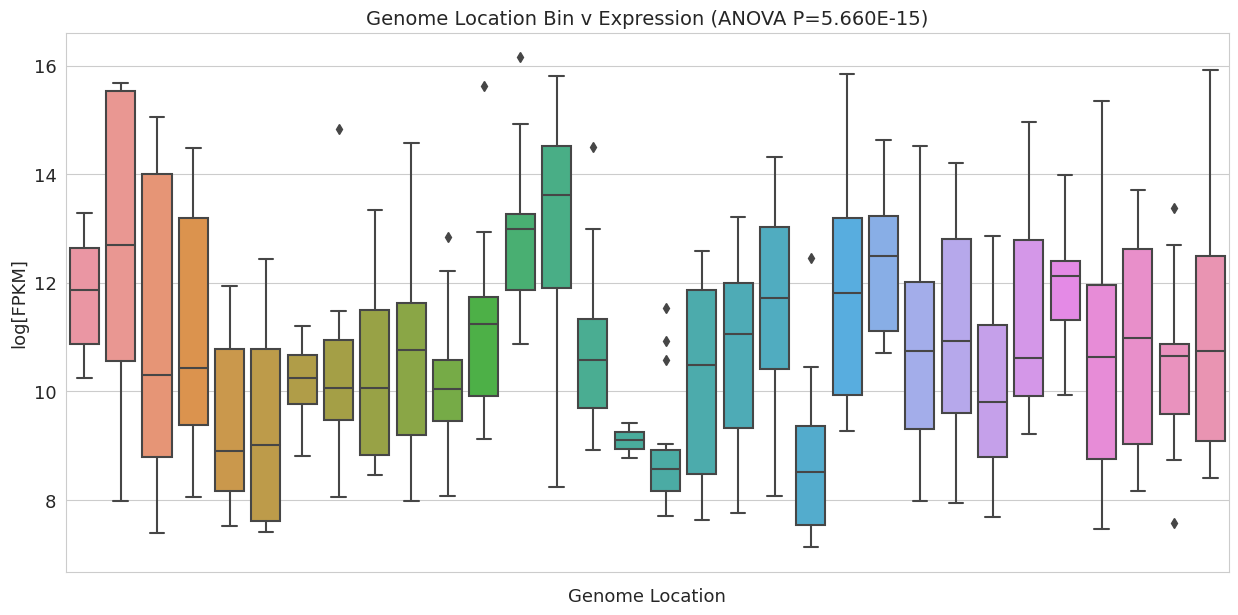

In [109]:
genome_loc_df = gene_table_ml[['genome_loc_cos', 'genome_loc_sin', 'log_tpm']].copy()
genome_loc_df['sincos'] = genome_loc_df.apply(
    lambda row: str(row.genome_loc_cos) + str(row.genome_loc_sin), axis=1
)

exp_groups = []
for sincos, gloc_df in genome_loc_df.groupby('sincos'):
    exp_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='sincos', y='log_tpm', data=genome_loc_df, ax=ax, dodge=True)
ax.tick_params(axis='both', labelsize=13)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels([])
ax.set_xlabel("Genome Location", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f'Genome Location Bin v Expression (ANOVA P={p:.3E})', fontsize=14);

## Order in TU

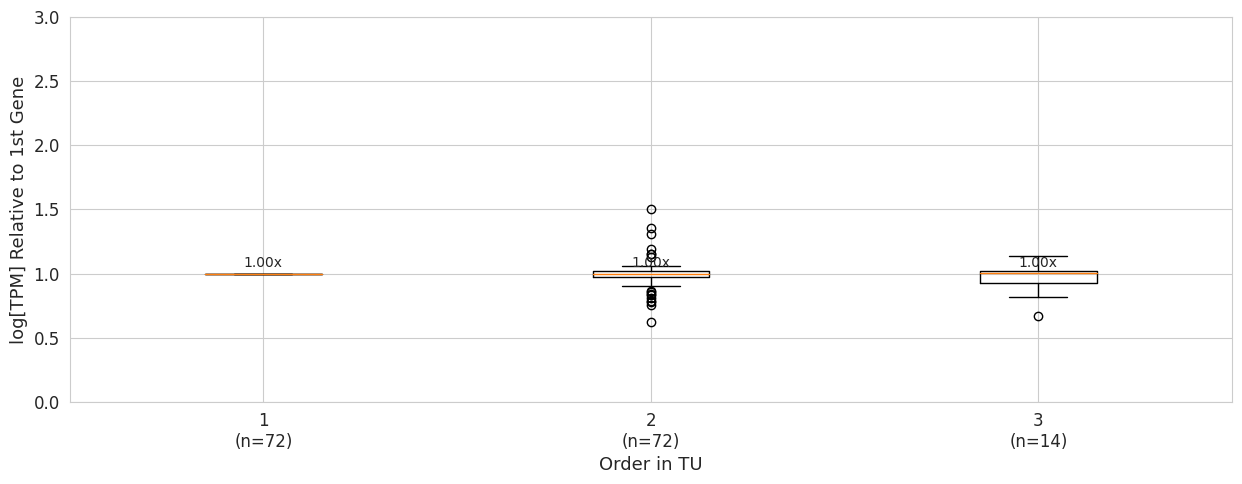

In [110]:
tu_rel_exps = {}

for tu_row in bs_168.tu_table.itertuples():

    tu_genes = bs_168._tu_to_genes[tu_row.Index]
    tu_gene_df = bs_168.gene_table[bs_168.gene_table.index.isin(tu_genes)].dropna(subset=['log_tpm'])

    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_tpm']) / sorted_gene_df['log_tpm'][0]
        
        for i, rel_exp in enumerate(tu_gene_exps_rel):
            if i in tu_rel_exps:
                tu_rel_exps[i].append(rel_exp)
            else:
                tu_rel_exps[i] = [rel_exp]
                
tu_rel_exps = {k: v for k, v in tu_rel_exps.items() if len(v) > 10}

_, ax = plt.subplots(figsize=(15, 5))

ax.boxplot(list(tu_rel_exps.values()))
ax.set_xticklabels([f'{i+1}\n(n={len(vals)})' for i, vals in enumerate(tu_rel_exps.values())])
ax.set_xlabel('Order in TU', fontsize=13)
ax.set_ylabel('log[TPM] Relative to 1st Gene', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(bottom=0, top=3)
for i, vals in enumerate(tu_rel_exps.values()):
    med = np.median(vals)
    ax.text(i+1, med+0.05, f'{med:.2f}x', ha='center')

## Distance to TSS

(0.0, 3.0)

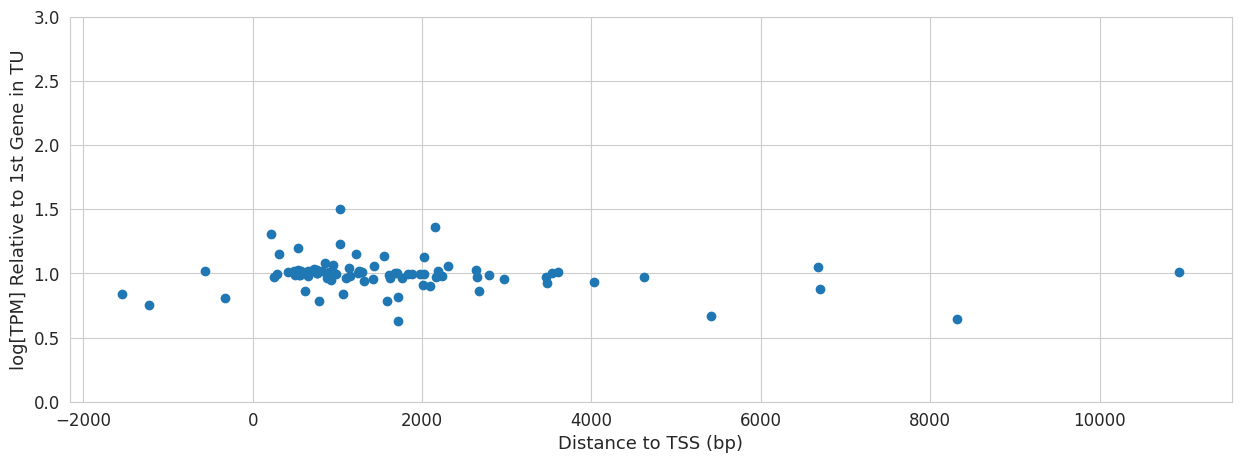

In [111]:
all_tss_dists = []
all_rel_exps_tss = []

for tu_row in bs_168.tu_table.itertuples():
    tu_genes = bs_168._tu_to_genes[tu_row.Index]
    tu_gene_df = bs_168.gene_table[bs_168.gene_table.index.isin(tu_genes)].dropna(subset=['log_tpm'])
    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
            tss_dists = sorted_gene_df['left'].values - tu_row.tss
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
            tss_dists = tu_row.tss - sorted_gene_df['right']
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_tpm']) / sorted_gene_df['log_tpm'][0]
        
        # ignore the first gene in the TU, this will just give us a bunch of y-values of 1 
        all_tss_dists += list(tss_dists[1:])
        all_rel_exps_tss += list(tu_gene_exps_rel[1:])
        
_, ax = plt.subplots(figsize=(15, 5))

ax.scatter(all_tss_dists, all_rel_exps_tss)
ax.set_xlabel('Distance to TSS (bp)', fontsize=13)
ax.set_ylabel('log[TPM] Relative to 1st Gene in TU', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(0, 3)

## TU Length

Text(0, 0.5, 'log[TPM]')

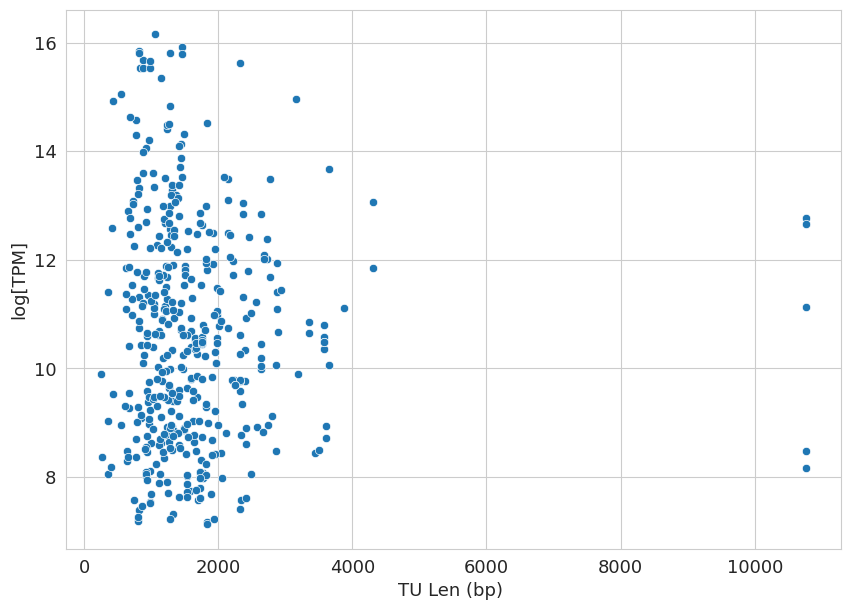

In [112]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU Len (bp) ", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## TU GC Content

Text(0, 0.5, 'log[FPKM]')

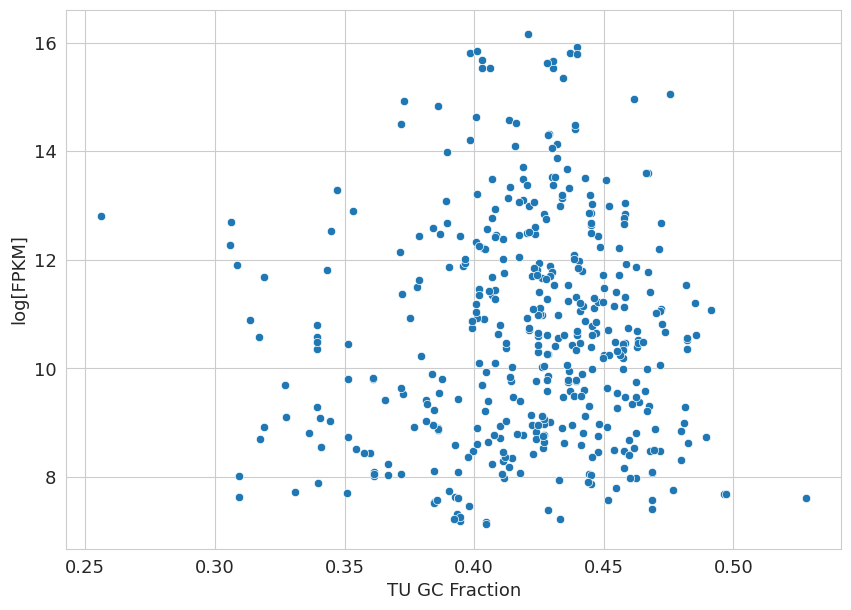

In [113]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU GC Fraction", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

## TSS Base

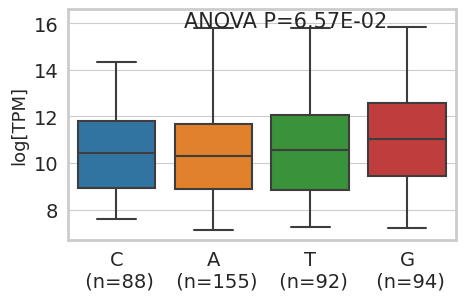

In [114]:
sns.set_style('whitegrid')

exp_groups = []
for tss_base, gloc_df in gene_table_ml.groupby('tss_base'):
    exp_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(x='tss_base', y='log_tpm', data=gene_table_ml, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
#ax.set_title(f"TSS Base (ANOVA P={p:.2E})", fontsize=14)
ax.text(0.3, 0.92, f"ANOVA P={p:.2E}", fontsize=15, transform=ax.transAxes)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={gene_table_ml[gene_table_ml['tss_base'] == lab.get_text()].shape[0]})"
    for lab in ax.get_xticklabels()
]);
for s in ax.spines.values():
    s.set_linewidth(2)
plt.savefig('expression_ml_figures/tss_base.svg')

## 5' UTR 

(0.0, 400.0)

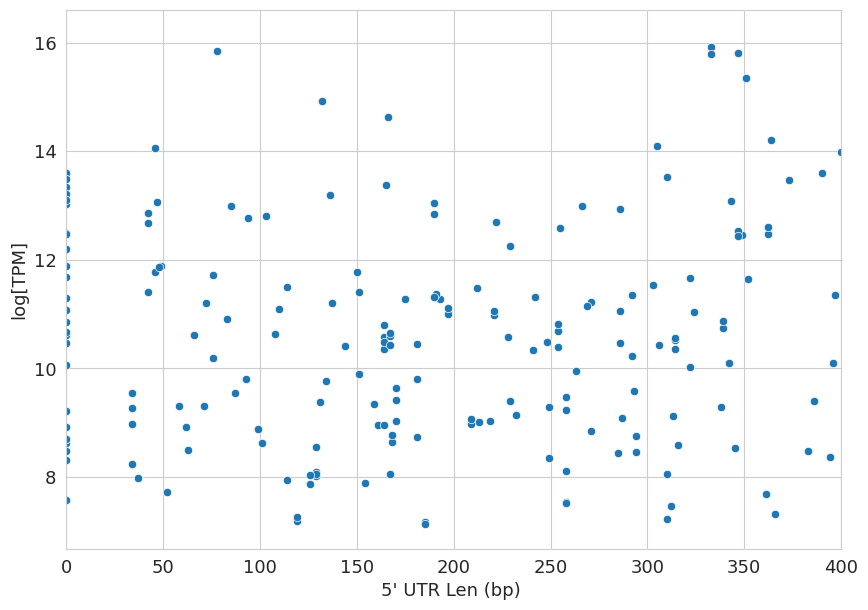

In [115]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR Len (bp) ", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xlim(0, 400)

Text(0, 0.5, 'log[TPM]')

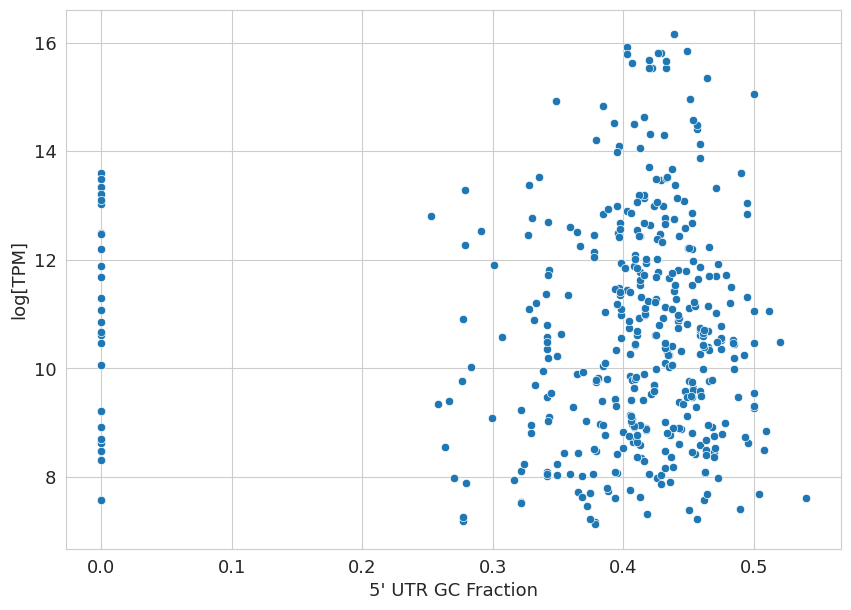

In [116]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR GC Fraction", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## -10 Box
#### Did not include cutoff

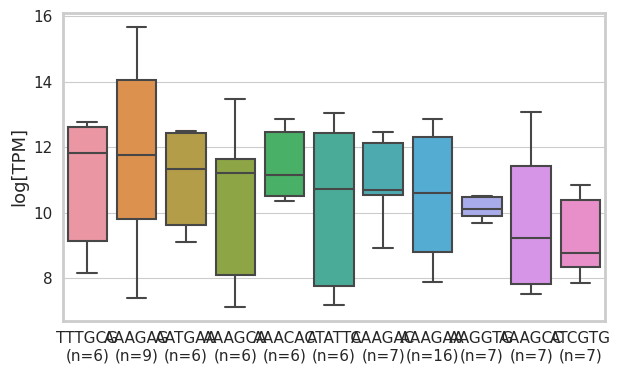

In [127]:
box_df = gene_table_ml[['box_10_seq', 'log_tpm']].dropna()
#print(box_df)
box_10_dfs = []

cutoff = 5
for _, b10seq_df in box_df.groupby('box_10_seq'):
    if b10seq_df.shape[0] > cutoff:
        box_10_dfs.append(b10seq_df)
    
        
box_10_dfs = sorted(box_10_dfs, key=lambda df: df['log_tpm'].median(), reverse=True)
box_10_df = pd.concat(box_10_dfs)

_, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x='box_10_seq', y='log_tpm', data=box_10_df, fliersize=0, ax=ax)
#sns.swarmplot(x='box_10_seq', y='log_tpm', data=box_10_df, ax=ax)
ax.tick_params(axis='both', labelsize=11)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_10_df[box_10_df['box_10_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()]);
# ax.set_title(f"-10 Box Sequence (n={len(box_df['box_10_seq'].unique())}; {len(box_10_dfs)} with >{cutoff} genes shown)",
#              fontsize=14)
for s in ax.spines.values():
    s.set_linewidth(2)
plt.savefig('expression_ml_figures/box_10.svg')

In [128]:
print(box_10_df)

          box_10_seq    log_tpm
locus_tag                      
BSU_37290     TTTGCG   8.156926
BSU_37310     TTTGCG  11.125905
BSU_37320     TTTGCG   8.477560
BSU_37330     TTTGCG  12.768014
BSU_37340     TTTGCG  12.657282
...              ...        ...
BSU_11450     ATCGTG  10.854778
BSU_23420     ATCGTG   8.031840
BSU_23430     ATCGTG   7.870280
BSU_36960     ATCGTG   8.633880
BSU_36970     ATCGTG   8.778952

[83 rows x 2 columns]


## Distance to TSS

Text(0, 0.5, 'log[TPM]')

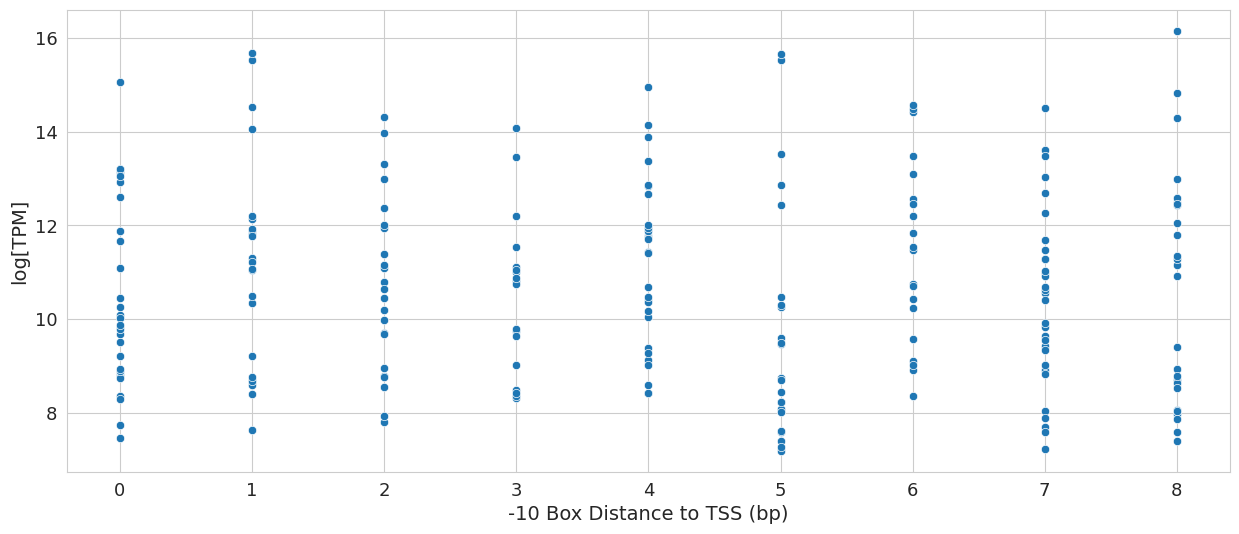

In [119]:
box_dist_df = gene_table_ml[['box_10_tss_dist', 'log_tpm']].dropna()
box_dist_df = box_dist_df[box_dist_df['box_10_tss_dist'] < 9]

_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='box_10_tss_dist', y='log_tpm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10 Box Distance to TSS (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

### Extended Box GC Content

Text(0, 0.5, 'log[TPM]')

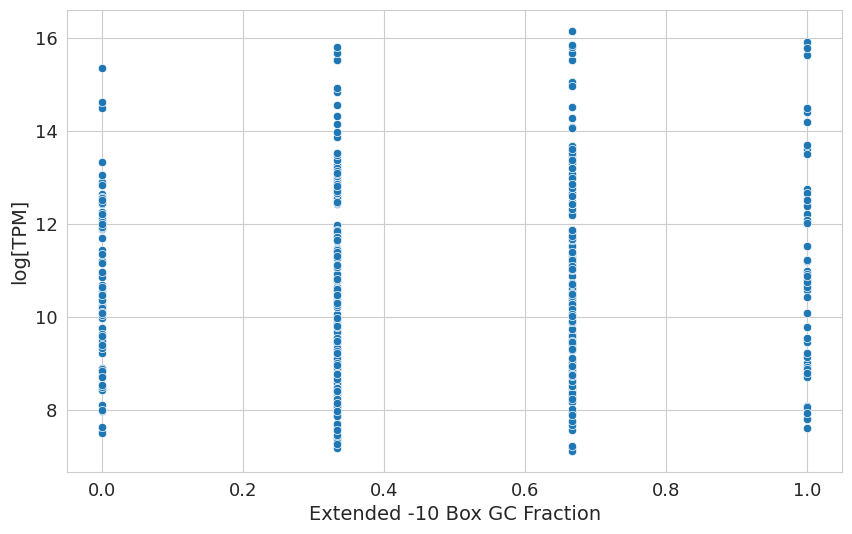

In [120]:
_, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='box_10_ext_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Extended -10 Box GC Fraction', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## -35 Box

Text(0.5, 1.0, '-35 Box Sequence (n=224; 12 genes shown)')

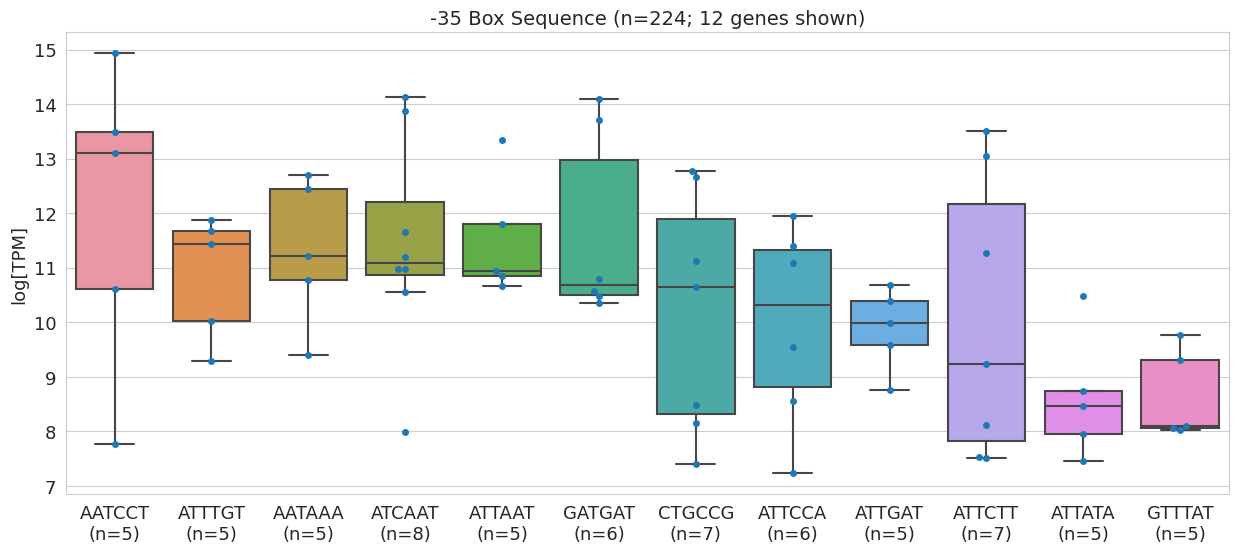

In [129]:
box_35_df_orig = gene_table_ml[['box_35_seq', 'log_tpm']].dropna()

box_35_dfs = []

cutoff = 4
for _, b35seq_df in box_35_df_orig.groupby('box_35_seq'):
    if b35seq_df.shape[0] > cutoff:
        box_35_dfs.append(b35seq_df)
        
box_35_dfs = sorted(box_35_dfs, key=lambda df: df['log_tpm'].median(), reverse=True)
box_35_df = pd.concat(box_35_dfs)

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='box_35_seq', y='log_tpm', data=box_35_df, fliersize=0, ax=ax)
sns.swarmplot(x='box_35_seq', y='log_tpm', data=box_35_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_35_df[box_35_df['box_35_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title(f"-35 Box Sequence (n={len(box_35_df_orig['box_35_seq'].unique())}; {len(box_35_dfs)} genes shown)",
             fontsize=14)

In [122]:
print(box_35_df)

          box_35_seq    log_tpm
locus_tag                      
BSU_14040     ATTATG   9.284240
BSU_31740     ATTATG  10.797962
BSU_40890     ATTATG  15.909292
BSU_40900     ATTATG  15.787069
BSU_04710     GTTGAT  13.136768
...              ...        ...
BSU_09150     GTTTAT   9.767707
BSU_20090     GTTTAT   8.087511
BSU_20100     GTTTAT   8.020739
BSU_20110     GTTTAT   8.060348
BSU_30739     GTTTAT   9.311791

[117 rows x 2 columns]


### Distance to TSS

Text(0, 0.5, 'log[TPM]')

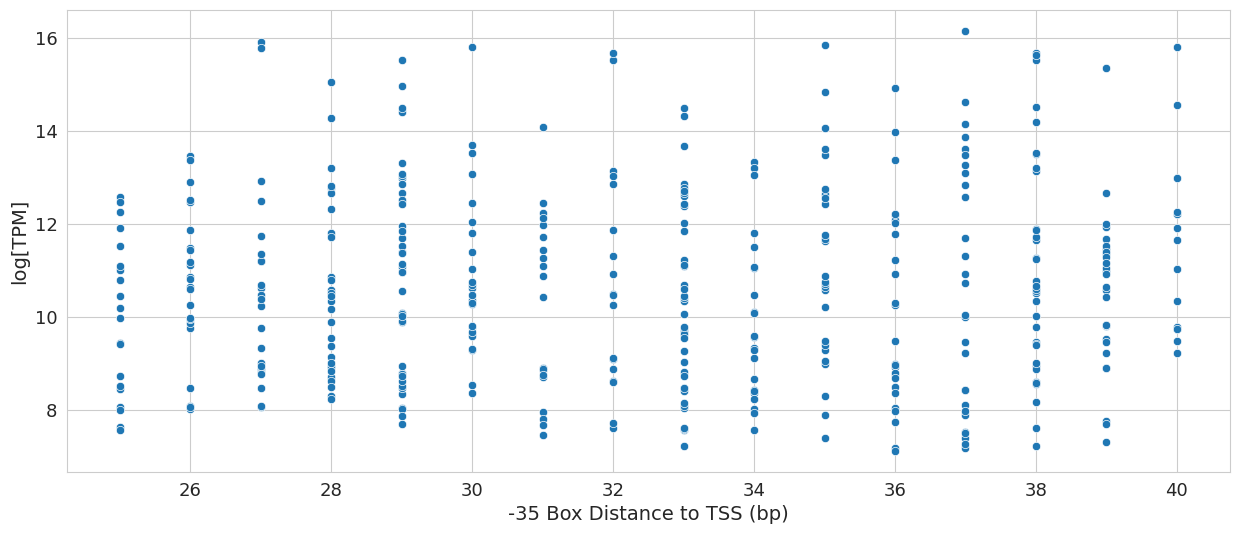

In [123]:
box_dist_df = gene_table_ml[['box_35_tss_dist', 'log_tpm']].dropna()

_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='box_35_tss_dist', y='log_tpm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-35 Box Distance to TSS (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## Spacer

Text(0, 0.5, 'log[TPM]')

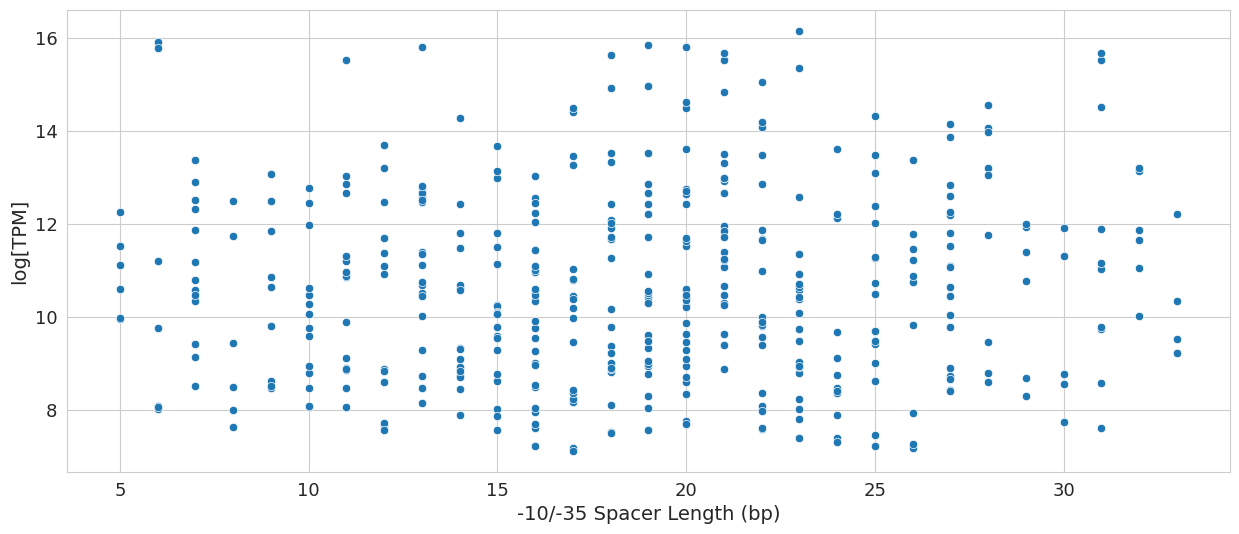

In [124]:
_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='spacer_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10/-35 Spacer Length (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

Text(0, 0.5, 'log[TPM]')

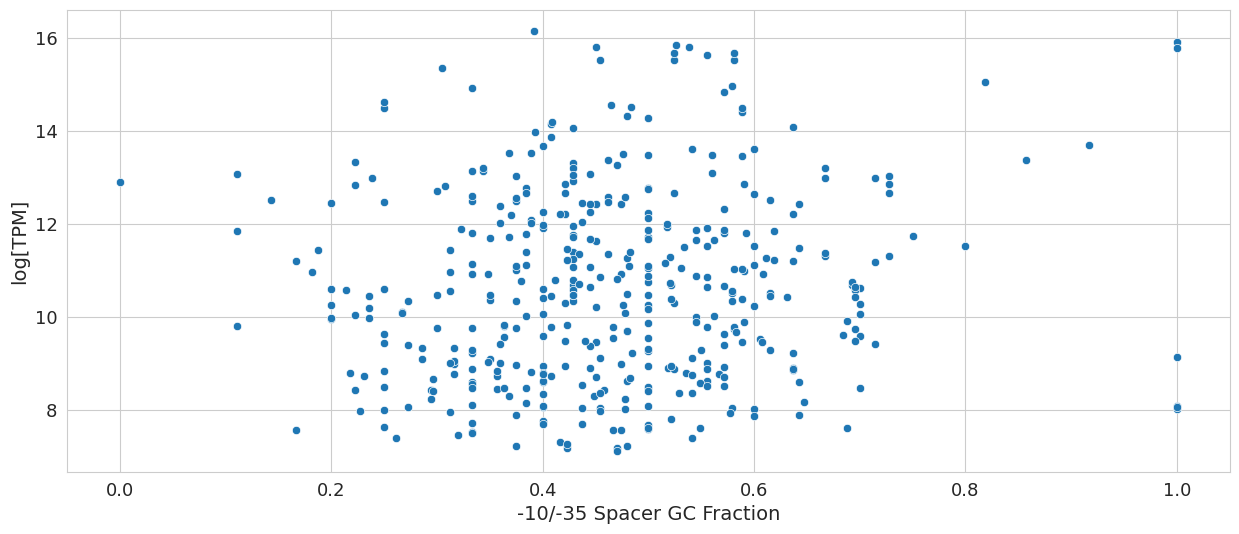

In [125]:
_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='spacer_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10/-35 Spacer GC Fraction', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## Regulatory Effect

Text(0.5, 1.0, 'BS_168 Expression by Regulatory Effect (P = 2.698E-19)')

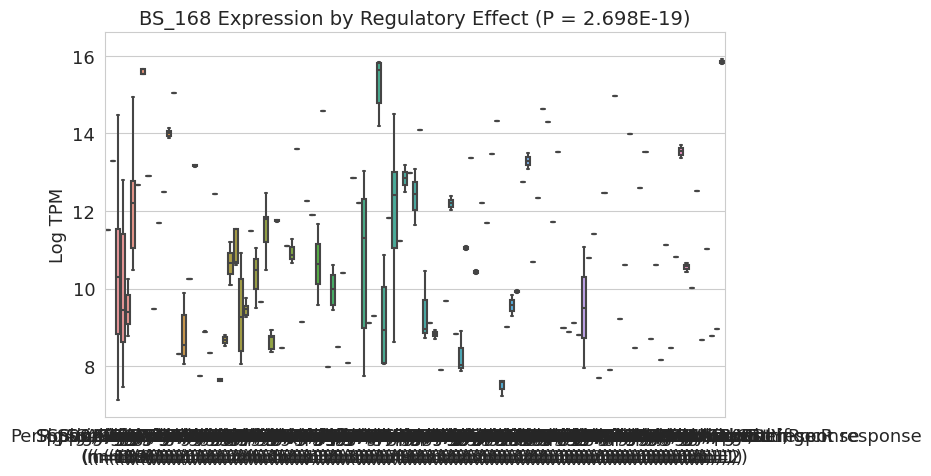

In [126]:
reg_effect_df = gene_table_ml.copy()
reg_effect_df['reg_effect'] = reg_effect_df['reg_effect'].fillna('none')

loc_groups = []
for loc, gloc_df in reg_effect_df.groupby('reg_effect'):
    loc_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*loc_groups)

_, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(x='reg_effect', y='log_tpm',
            data=reg_effect_df, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_xticklabels([f"{lab.get_text()}\n(n={reg_effect_df[reg_effect_df['reg_effect'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_xticklabels()])    
ax.set_ylabel('Log TPM', fontsize=13)
ax.set_title(f'BS_168 Expression by Regulatory Effect (P = {p:.3E})', fontsize=14)